In [85]:
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin

BASE = "https://www.amazon.ca"
params = {"k": "backpack"}
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "Accept-Language": "en-CA,en;q=0.9",
}

resp = requests.get(f"{BASE}/s", params=params, headers=headers, timeout=20)
soup = BeautifulSoup(resp.text, "lxml")  

cards = soup.select('div.s-main-slot div[data-component-type="s-search-result"]')
print(f"Found {len(cards)} result cards")

c0 = cards[0]
print("Has H2? ->", bool(c0.select_one("h2")))
print("Title anchor? ->", bool(c0.select_one("h2 a")))
print("Price .a-offscreen? ->", bool(c0.select_one("span.a-price span.a-offscreen")))
print("Rating .a-icon-alt? ->", bool(c0.select_one("span.a-icon-alt")))
print("Review count candidates ->", len(c0.select("span.s-underline-text")))
# If needed, dump the first card to inspect
open("first_card.html", "w", encoding="utf-8").write(c0.prettify())
print("Wrote first_card.html for inspection")


Found 60 result cards
Has H2? -> True
Title anchor? -> False
Price .a-offscreen? -> True
Rating .a-icon-alt? -> True
Review count candidates -> 1
Wrote first_card.html for inspection


In [87]:

def txt(el):
    return el.get_text(strip=True) if el else None

rows = []
n_no_anchor = n_no_title = 0

for c in cards:
    # Title: try an <a> first; if absent, fall back to h2 text or common span classes
    a = c.select_one("h2 a")  # often absent in bot-lite HTML
    title = None
    url = None
    if a:
        title = txt(a)
        if a.has_attr("href"):
            url = urljoin(BASE, a["href"])
    else:
        n_no_anchor += 1
        h2 = c.select_one("h2")
        title = txt(h2)
        # sometimes title is in these spans:
        if not title:
            title = txt(c.select_one("h2 span.a-size-base-plus")) or \
                    txt(c.select_one("h2 span.a-size-medium")) or \
                    txt(c.select_one("h2 span"))

    # Price (use full text in .a-offscreen)
    price = txt(c.select_one("span.a-price > span.a-offscreen") or c.select_one("span.a-offscreen"))

    # Rating and reviews
    rating = txt(c.select_one("span.a-icon-alt"))
    reviews = txt(
        c.select_one('span[aria-label$="ratings"]') or
        c.select_one('span[aria-label$="rating"]') or
        c.select_one("span.s-underline-text")
    )

    if title:
        rows.append({"title": title, "price": price, "rating": rating, "reviews": reviews, "url": url})
    else:
        n_no_title += 1

print("Cards with no anchor (likely bot-lite DOM):", n_no_anchor)
print("Cards where we still couldn't get a title:", n_no_title)

df = pd.DataFrame(rows).dropna(subset=["title"])
print("Extracted rows:", len(df))
print(df.head(5))

df.to_csv("amazon_backpacks.csv", index=False, encoding="utf-8")
print("Saved amazon_backpacks.csv")


Cards with no anchor (likely bot-lite DOM): 60
Cards where we still couldn't get a title: 0
Extracted rows: 60
                                               title    price  \
0  KEOFID classic carry-on travel backpack for me...   $37.99   
1  SUPACOOL Casual Laptop Backpack with USB Charg...   $34.99   
2  SUPACOOL Lightweight Casual Backpack for Men a...   $36.99   
3  tomtoc Travel Backpack, TSA Friendly Flight Ap...  $123.89   
4  MATEIN Travel Laptop Backpack, Business Anti T...   $35.99   

               rating  reviews   url  
0  4.6 out of 5 stars     (2K)  None  
1  4.2 out of 5 stars   (5.1K)  None  
2  4.5 out of 5 stars    (245)  None  
3  4.7 out of 5 stars    (416)  None  
4  4.6 out of 5 stars  (97.7K)  None  
Saved amazon_backpacks.csv


In [89]:
import pandas as pd
import re
import numpy as np


In [91]:
df = pd.read_csv("amazon_backpacks.csv")

In [93]:
df

,title,price,rating,reviews,url
0,KEOFID classic carry-on travel backpack for me...,$37.99,4.6 out of 5 stars,(2K),NaN
1,SUPACOOL Casual Laptop Backpack with USB Charg...,$34.99,4.2 out of 5 stars,(5.1K),NaN
2,SUPACOOL Lightweight Casual Backpack for Men a...,$36.99,4.5 out of 5 stars,(245),NaN
3,"tomtoc Travel Backpack, TSA Friendly Flight Ap...",$123.89,4.7 out of 5 stars,(416),NaN
4,"MATEIN Travel Laptop Backpack, Business Anti T...",$35.99,4.6 out of 5 stars,(97.7K),NaN
5,"MATEIN Travel Laptop Backpack, 17 inch Busines...",$32.29,4.6 out of 5 stars,(9.3K),NaN
6,School Backpack for Women Men College High Sch...,$29.99,4.4 out of 5 stars,(518),NaN
7,SUPACOOL Casual Laptop Backpack with USB Charg...,$34.99,4.2 out of 5 stars,(5.1K),NaN
8,"Backpack for Men and Women,School Backpack for...",$39.99,4.4 out of 5 stars,(6K),NaN
9,"YOREPEK Travel Backpack, Extra Large 50L Lapto...",$41.99,4.5 out of 5 stars,(47.8K),NaN


In [95]:
def parse_price(s):
    if pd.isna(s): return np.nan
    s = str(s).replace("$", "").replace(",", "").strip()
    try:
        return float(s)
    except:
        return np.nan

def parse_rating(s):
    if pd.isna(s): return np.nan
    m = re.search(r"(\d+\.\d+)", str(s))
    return float(m.group(1)) if m else np.nan

def parse_reviews(s):
    if pd.isna(s): return np.nan
    t = str(s).strip("()").replace(",", "").upper()
    if "K" in t:
        return int(float(t.replace("K",""))*1000)
    if "M" in t:
        return int(float(t.replace("M",""))*1_000_000)
    return int(re.sub(r"\D", "", t)) if re.search(r"\d", t) else np.nan

# --- Apply cleaning ---
df["price_num"]   = df["price"].apply(parse_price)
df["rating_num"]  = df["rating"].apply(parse_rating)
df["reviews_num"] = df["reviews"].apply(parse_reviews)

# Preview
print(df[["title","price_num","rating_num","reviews_num"]].head(10))

                                               title  price_num  rating_num  \
0  KEOFID classic carry-on travel backpack for me...      37.99         4.6   
1  SUPACOOL Casual Laptop Backpack with USB Charg...      34.99         4.2   
2  SUPACOOL Lightweight Casual Backpack for Men a...      36.99         4.5   
3  tomtoc Travel Backpack, TSA Friendly Flight Ap...     123.89         4.7   
4  MATEIN Travel Laptop Backpack, Business Anti T...      35.99         4.6   
5  MATEIN Travel Laptop Backpack, 17 inch Busines...      32.29         4.6   
6  School Backpack for Women Men College High Sch...      29.99         4.4   
7  SUPACOOL Casual Laptop Backpack with USB Charg...      34.99         4.2   
8  Backpack for Men and Women,School Backpack for...      39.99         4.4   
9  YOREPEK Travel Backpack, Extra Large 50L Lapto...      41.99         4.5   

   reviews_num  
0         2000  
1         5100  
2          245  
3          416  
4        97700  
5         9300  
6          

In [97]:
print("Average price: $", round(df["price_num"].mean(),2))
print("Average rating:", round(df["rating_num"].mean(),2))
print("Median reviews:", int(df["reviews_num"].median()))
print("Most expensive backpack: $", df["price_num"].max())
print("Cheapest backpack: $", df["price_num"].min())


Average price: $ 49.37
Average rating: 4.51
Median reviews: 733
Most expensive backpack: $ 219.95
Cheapest backpack: $ 13.99


In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")


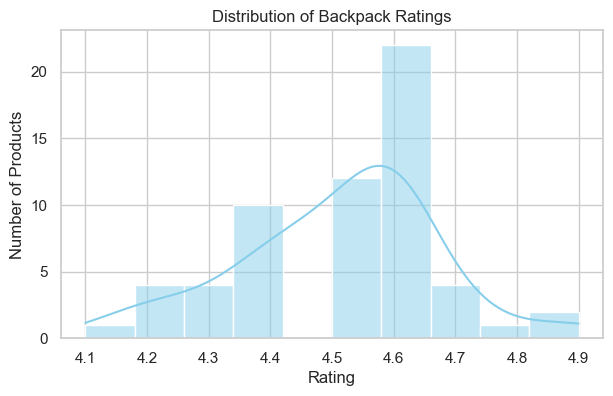

In [101]:
# ---- 1. Ratings Distribution ----
plt.figure(figsize=(7,4))
sns.histplot(df["rating_num"].dropna(), bins=10, kde=True, color="skyblue")
plt.title("Distribution of Backpack Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Products")
plt.show()


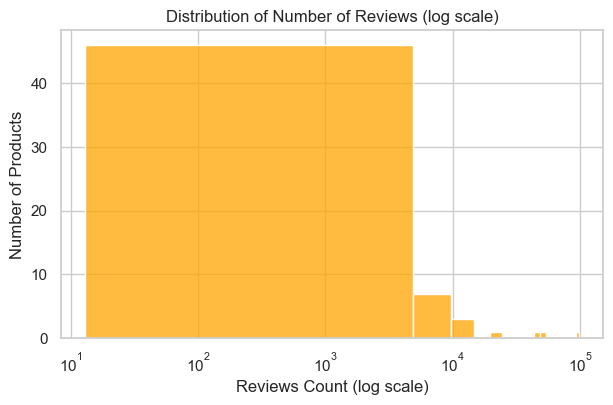

In [103]:
# ---- 2. Reviews Distribution (log scale, since reviews vary a lot) ----
plt.figure(figsize=(7,4))
sns.histplot(df["reviews_num"].dropna(), bins=20, color="orange")
plt.xscale("log")
plt.title("Distribution of Number of Reviews (log scale)")
plt.xlabel("Reviews Count (log scale)")
plt.ylabel("Number of Products")
plt.show()

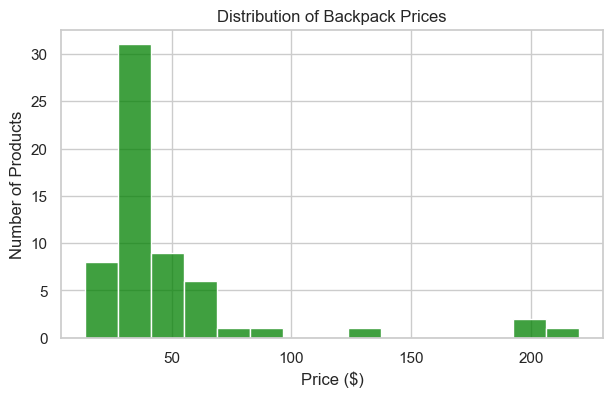

In [104]:
# ---- 3. Price Distribution ----
plt.figure(figsize=(7,4))
sns.histplot(df["price_num"].dropna(), bins=15, color="green")
plt.title("Distribution of Backpack Prices")
plt.xlabel("Price ($)")
plt.ylabel("Number of Products")
plt.show()

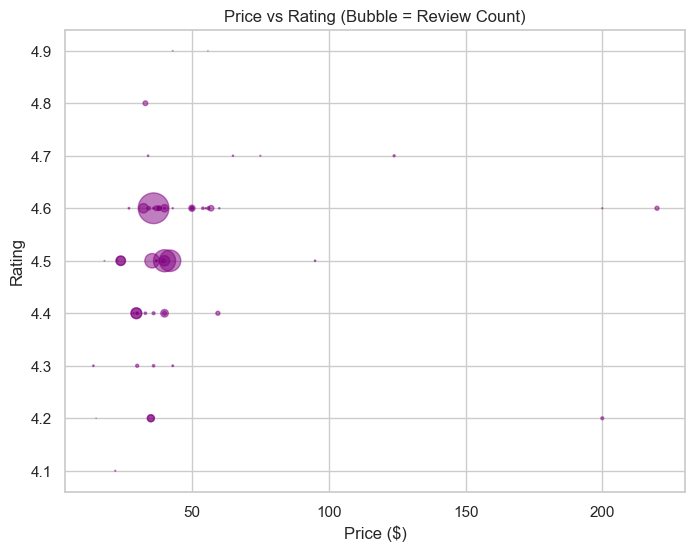

In [106]:
# ---- 4. Price vs Rating Scatter (bubble size = reviews) ----
plt.figure(figsize=(8,6))
plt.scatter(df["price_num"], df["rating_num"], 
            s=df["reviews_num"]/200, alpha=0.5, c="purple")
plt.title("Price vs Rating (Bubble = Review Count)")
plt.xlabel("Price ($)")
plt.ylabel("Rating")
plt.show()

In [109]:
filtered = df[df["reviews_num"] >= 100]

highest_rated_real = filtered.sort_values(by="rating_num", ascending=False).head(10)
lowest_rated_real = filtered.sort_values(by="rating_num", ascending=True).head(10)

print("\nTop 10 Highest Rated (≥100 reviews):")
print(highest_rated_real[["title","price_num","rating_num","reviews_num"]])

print("\nBottom 10 Lowest Rated (≥100 reviews):")
print(lowest_rated_real[["title","price_num","rating_num","reviews_num"]])



Top 10 Highest Rated (≥100 reviews):
                                                title  price_num  rating_num  \
36  Laptop Backpack for Women Bag: 15.6 inch Work ...      32.99         4.8   
3   tomtoc Travel Backpack, TSA Friendly Flight Ap...     123.89         4.7   
42  Herschel Supply Co. Unisex-Adults Classic Back...      65.00         4.7   
34  40L Travel Backpack with USB Charging Port, Wa...      33.99         4.7   
0   KEOFID classic carry-on travel backpack for me...      37.99         4.6   
45               Samsonite Classic Leather Slim Brief     219.95         4.6   
40  WINDARS School Backpack for Teen Girls, Cute C...      35.99         4.6   
28  Backpack for Men and Women, School Backpacks f...      36.99         4.6   
26  Canvas School Laptop Backpack, Durable Rucksac...      34.19         4.6   
25  Extra Large 50L Travel Laptop Backpack for Men...      49.99         4.6   

    reviews_num  
36         2300  
3           416  
42          164  
34       

In [111]:
from collections import Counter
import re

# Define some stopwords (can expand this list)
stopwords = {"backpack","bag","inch","for","with","men","women","adult","school","college","unisex","extra","large"}

def get_keywords(titles):
    text = " ".join(titles).lower()
    words = re.findall(r"[a-zA-Z]+", text)  # keep only words
    words = [w for w in words if w not in stopwords and len(w) > 2]
    return Counter(words).most_common(15)

# Top 10 keywords
top_keywords = get_keywords(top10["title"])
print("Top 10 Keywords in Highest Rated:\n", top_keywords)

# Bottom 10 keywords
bottom_keywords = get_keywords(bottom10["title"])
print("\nTop 10 Keywords in Lowest Rated:\n", bottom_keywords)


Top 10 Keywords in Highest Rated:
 [('laptop', 8), ('travel', 8), ('water', 6), ('resistant', 6), ('usb', 5), ('business', 5), ('work', 4), ('computer', 4), ('black', 4), ('charging', 4), ('port', 4), ('backpacks', 3), ('tsa', 3), ('approved', 3), ('carry', 3)]

Top 10 Keywords in Lowest Rated:
 [('travel', 6), ('laptop', 5), ('lightweight', 5), ('casual', 4), ('usb', 4), ('port', 4), ('and', 4), ('bookbag', 4), ('backpacks', 4), ('daypack', 4), ('charging', 3), ('pack', 3), ('back', 3), ('black', 3), ('boys', 3)]


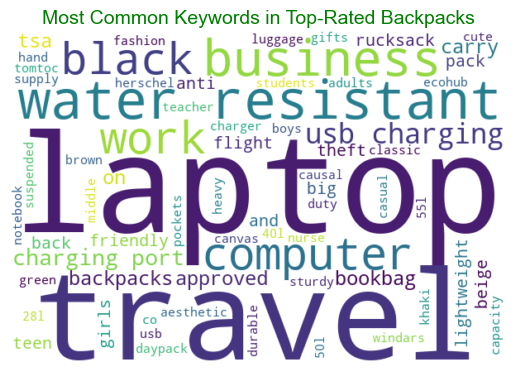

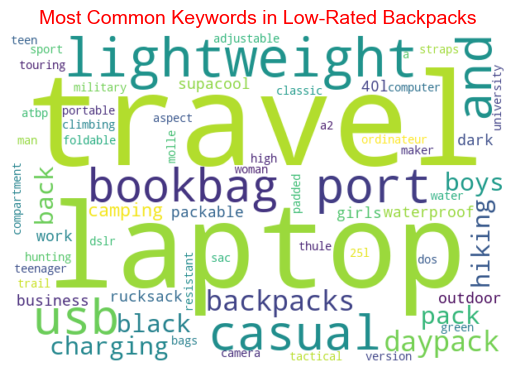

In [113]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(titles, title_str, color="black"):
    text = " ".join(titles).lower()
    wc = WordCloud(width=600, height=400, background_color="white", colormap="viridis",
                   stopwords=stopwords).generate(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title_str, fontsize=14, color=color)
    plt.show()

# Wordclouds
plot_wordcloud(top10["title"], "Most Common Keywords in Top-Rated Backpacks", "green")
plot_wordcloud(bottom10["title"], "Most Common Keywords in Low-Rated Backpacks", "red")
